[dataset: FSD50k (Free Sound Dataset 50k)](https://zenodo.org/record/4060432#.X5ySHHhKgWo)


Thesis: Classify raw audio files into categories associated with household noises to identify emergency related sounds(humans (voice), animals, instruments, water, door, car, explosion (boom, thunder).

### 3 Main CNN Models:

1. CNN with Wave Spectrograms
2. CNN with MFCC Spectrograms
3. CNN with Mean Values of MFCC Features

In [1]:
import pandas as pd
import numpy as np
import time
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from PIL import Image
import skimage
import skimage.io
import os
import pickle
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.
/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Mateo/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Mateo/opt/anaconda3/lib/python3.7/sit

# Begin MODELING

In [418]:
# #pd.read_csv() not working for some reason 

# USE JSON! orginal data was in json!

dev_info = pd.read_json('data/labelled_dev_info.json')

In [419]:
dev_info.head()

,title,description,tags,license,uploader,track_num,wav_name,png_name,labels
63,RalfHutterWorking.wav,"Ralf Hutter from Kraftwerk saying ""Working on ...","[male, voice]",http://creativecommons.org/licenses/by/3.0/,fectoper,63,63.wav,63.png,0
136,keyboard-rhymtic.wav,Noise of an average logitech keyboard. Pretty ...,"[keyboard, rhythmic, tap, type]",http://creativecommons.org/licenses/by/3.0/,Anton,136,136.wav,136.png,11
137,keyboard-typing.wav,Noise of an average logitech keyboard. Pretty ...,"[computer, environmental-sounds-research, key,...",http://creativecommons.org/licenses/by/3.0/,Anton,137,137.wav,137.png,8
221,bell.wav,simple *ting* sound,[bell],http://creativecommons.org/publicdomain/zero/1.0/,Erratic,221,221.wav,221.png,5
236,BUSSES.aiff,Departing busses\r\n at Utrecht Central Railwa...,"[bus, depart, drive, station]",http://creativecommons.org/licenses/by-nc/3.0/,hanstimm,236,236.wav,236.png,7


In [420]:
dev_info.dtypes

title          object
description    object
tags           object
license        object
uploader       object
track_num       int64
wav_name       object
png_name       object
labels          int64
dtype: object

In [436]:
data_dir = '/Users/Mateo/Springboard/FSD50k/data/'
audio_dir = '/Users/Mateo/Springboard/FSD50k/data/FSD50K.dev_audio/'
list_of_wav_names = meta_train.wav_name.to_list()
list_of_png_names = meta_train.png_name.to_list()

In [442]:
label_dict ={
    0: 'human',
    1: 'comedy',
    2: 'door',
    3: 'baby',
    4: 'animal',
    5: 'music',
    6: 'percussion',
    7: 'machines',
    8: 'ambient',
    9: 'fire',
    10: 'movement',
    11: 'household',
    12: 'foley',
    13: 'nature',
    14: 'other'    
}

## Sanity Check For Mini Dataframe (2000)

In [422]:
df_2000 = dev_info.iloc[:2000].copy()

In [423]:
df_2000.shape

(2000, 9)

In [424]:
# target variable(y_train)
# target_labels = dev_100_df['labels']

target_labels = dev_info['labels']

In [425]:
target_labels

63         0
136       11
137        8
221        5
236        7
          ..
435288     1
435414     9
435415     9
435557    12
435559     9
Name: labels, Length: 40966, dtype: int64

# 1. CNN from Spectogram (move to first position)


### Notes on Architecture:(https://github.com/GorillaBus/urban-audio-classifier/blob/master/3-cnn-model-mfcc.ipynb)
    
   Convolutional layers and filter amounts: each convolutional layer will learn different features from the training data. The first layers will always learn more low level features (like lines and dots on an image, for example), while the following layers will learn more high-level patterns (basic shapes). The more complex the data is in means of patterns, the more convolutional layers that will be required learn them.
On the other hand, there will always be less low-level patterns and more high-level patters (formed by combinations of those lower level patterns), that's why we keep increasing the amount of filters as we add convolutional layers to the network.

Kernel sizes: I'm using one 5x5 and 3x3 kernel sizes as the smallest size that worked out on my experiments. I also tested 7x7 -as saw on some image classifiers- but they didn't work well with this data. Also notice I use odd numbers for kernel sizes, this is a very important rule and here is an excellent explanation Stackoverflow.

Batch normalization: In short, it normalizes the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This process optimizes training time. There is a friendly introduction to batch normalization .

MaxPooling: a common technique to downsample our data reducing dimensionality, if not familiarized have a look at this article from computersciencewiki.org.

Spatial dropout: A regularization method that works like the standard dropout used in neural networks, that applies better for convolutional layers: it works by dropping out entire feature maps by a given rate, preventing activations from becoming strongly correlated. It's effect is usually more sensible than the standard dropout and as you may have advertised I'm increasing the rate as I add new layers, this is a common practice as higher level layers are also containing more filters. Another important advice is to use it after max pooling.

GlobalAveragePooling: until some years ago it was mostly common to see CNN architectures that would flatten out the output from the last convolutional layer to connect it to a series of dense layers that would "interprete" and make category predictions. Today is more common to see this dense layers replaced with a Global Average Pooling layer that calculates the average output of each feature map in the previous layer, strongly reducing dimensionality. This demonstrated to work better in many scenarios, also being much more computationally cheap. Read more in this article.

Dense (softmax output): the final layer containing the softmax output that will provide the classification probabilities for the input data.


### Notes on Keras/ Documentation

Conv2D documentation: https://keras.io/api/layers/convolution_layers/convolution2d/
MaxPooling2D: https://keras.io/api/layers/pooling_layers/max_pooling2d/
Dropout: https://keras.io/api/layers/regularization_layers/dropout/
Flatten: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten
Dense: https://keras.io/api/layers/core_layers/dense/


Conv2D
the first number (32) represents 'filters', or how many outputs for this layer (that's why it grows for each Conv2D)
- these filters are the same as nodes (maybe not)
kernel_size = size of sliding window
default: strides = (1,1)
default: padding = 'valid' (means 'none', switch to 'same' for equal padding for all kernels/windows)

MaxPooling2D:
pool_size: dimensions of pixels to analyze, aggegrating by the max value
strides = default, switch uses dimensions of pool_size for sliding window (thus does not aggegrate overlapping pixels)
padding = default, which is 'valid'(none), 'same' creates equal padding (better no?)

Dropout:
Fraction of the input units to drop.
The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time
I believe that means that one designates the percentage of input dropped, that are randomly (not evenly) spaced?

Flatten
takes a multi-dimensioned matrix, and converts it into a 1-d array.
i.e. An output from a Conv2D layer with a shape of (1,10,64) passed through Flatten would have a shape of (640,)

Dense:
Just your regular densely-connected NN layer. 
-(a fully connected layer? as opposed to a Convutional layer, which is like a sliding window?)
units: Positive integer, dimensionality of the output space.
activation: Activation function to use. Commonly 'relu' when a binary output is desired
-softmax is generally used for the final output layer on multiclassification problems).


Optimizer/ Compile:
alternate Optimizers in compiling (as opposed to SGD Stochastic Gradient Descent)
(note: also use sparse_categorical_crossentropy with numeric input for label in .flow_from_dataframe)

optimizer = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
optimizer = keras.optimizers.adam()
optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)



Note: Consider adding a Keras BatchNormilization layer (between linear and nonlinear layers, after flatten?)


Feature dimensions (MFCC x Time)


### loading ONE image from Spectrogram directory 

(128, 216)
(128, 216)


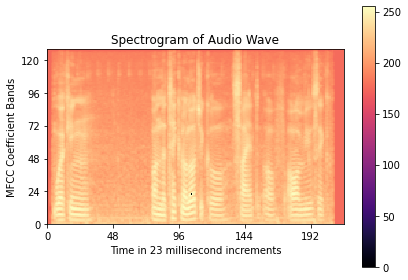

In [542]:
# loading Spectrogram (sanity check)

spec_images_dir = data_dir + 'spec_50k/'
file_path = spec_images_dir + list_of_png_names[0]

# loading processed MFCC Spectrogram Images
spec = skimage.io.imread(file_path)
print(spec.shape)
librosa.display.specshow(spec)

plt.ylabel('MFCC Coefficient Bands')
plt.xlabel('Time in 23 millisecond increments')
plt.title('Spectrogram of Audio Wave')
plt.yticks(range(0,128, 24))
plt.xticks(range(0,217, 48))
plt.colorbar()

plt.title('Spectrogram of Audio Wave')
skimage.io.imshow(file_path)

In [429]:
# load data into generator with keras function .flow_from_directory

datagen=ImageDataGenerator(rescale=1./255., validation_split=0) 
# 25% test set before, thats why only 75 before, seperate  eval so validiation =0


train_generator=datagen.flow_from_dataframe(
    dataframe= df_2000,
    directory= '/Users/Mateo/Springboard/FSD50k/data/spec_50k',
    x_col='png_name',
    y_col= 'labels',
    subset="training",
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=  "raw", # using 'raw' for numeric input # strings passed into   did not work "categorical",
    target_size=(128,216)) # target_size=(64,64)) tuple of height/width

Found 2000 validated image filenames.


In [431]:
num_classes= 15 # meta_train.labels.nunique() # 15 classes

#Define Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128,216,1))) # Height, Width, Num_channels
# seems like this should be just 1 channel, but asked for three, check this out later
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

#Compile   # had to switch to sparse_categorical_crossentropy from categorical_crossentropy
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.adam(), metrics=['accuracy'])

print(model.summary())

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 126, 214, 32)      320       
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 124, 212, 64)      18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 62, 106, 64)       0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 62, 106, 64)       0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 420608)            0         
_________________________________________________________________
dense_113 (Dense)            (None, 128)               53837952  
_________________________________________________________________
dropout_66 (Dropout)         (None, 128)             

In [443]:
#Train and Test The Model
model.fit(train_generator, epochs=1, verbose=1)    # switched to 5 from 10

Epoch 1/1
63/63 [==============================] - 148s 2s/step - loss: 2.0870 - accuracy: 0.3970


In [444]:
preds = model.predict(train_generator)
preds[0]

array([2.8486812e-02, 2.0732591e-04, 3.8906531e-03, 3.1072876e-04,
       5.5699021e-01, 3.6331746e-01, 9.0542082e-03, 6.6901250e-03,
       7.4964087e-03, 3.6612533e-03, 2.1697080e-04, 8.2604811e-03,
       6.6424855e-03, 1.9773454e-03, 2.7974390e-03], dtype=float32)

In [470]:
def pred_checker(track_num):
    pred_index = np.argmax(preds[track_num])

    # checking what the audio file is
    print("Description of Audio file:", df_2000.iloc[track_num]['description'])

    print('\nPredicted Class:', label_dict[pred_index],'\nTrue Class:', label_dict[df_2000.iloc[track_num]['labels']])

    # Lets play the audio 

    file_path = audio_dir + list_of_wav_names[track_num]
    data, sr = librosa.load(file_path)

    sound = ipd.Audio(file_path)
    return sound

In [481]:
pred_checker(44)
#  for fuller track info: df_2000.iloc[track_num]

Description of Audio file: Small 
shekere
     hit with palm, a bit of 
reverb
     coming from the gourd. Recorded as 22khz
 sample in 1987.

Predicted Class: machines 
True Class: music


In [299]:
# Evaluating the model on the training and testing set

score = model.evaluate(train_generator)
accuracy = 100*score[1]
print("Training accuracy: %.2f%%" % accuracy) 

63/63 [==============================] - 24s 388ms/step
Training accuracy: 38.30%


# 2. CNN with MFCC Spectrogram

(13, 216)


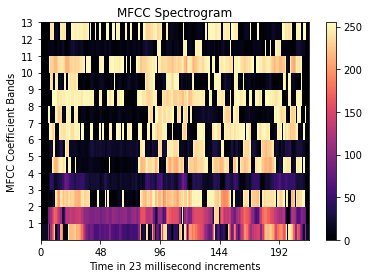

In [540]:
# loading one MFCC Spectrogram

spec_images_dir = data_dir + 'mfcc_50k/'
file_path = spec_images_dir + list_of_png_names[0]


# loading processed MFCC Spectrogram Images
spec = skimage.io.imread(file_path)
print(spec.shape)
librosa.display.specshow(spec)

plt.ylabel('MFCC Coefficient Bands')
plt.xlabel('Time in 23 millisecond increments')
plt.title('MFCC Spectrogram')
plt.yticks(range(1,14))
plt.xticks(range(0,217, 48))
plt.colorbar()

plt.show()

In [505]:
# loading MFCC Spectrograms into generator 

datagen=ImageDataGenerator(rescale=1./255.)  # default: validation_split=0
# 25% test set before, thats why only 75 before, seperate  eval so validiation =0


mfcc_train_generator=datagen.flow_from_dataframe(
    dataframe= df_2000,
    directory= '/Users/Mateo/Springboard/FSD50k/data/mfcc_50k',
    x_col='png_name',
    y_col= 'labels',
    subset="training",
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode=  "raw", # strings passed into   did not work "categorical",
    target_size=(13,216)) # target_size=(64,64)) tuple of height/width



# # test generator (need to create spectrograms first!)

# datagen=ImageDataGenerator(rescale=1./255.)  # default: validation_split=0
# # 25% test set before, thats why only 75 before, seperate  eval so validiation =0


# mfcc_test_generator=datagen.flow_from_dataframe(
#     dataframe= REPLACE WITH EVAL_INFO,
#     directory= '/Users/Mateo/Springboard/FSD50k/data/REPLACE WITH EVAL DIRECTORY OF SPECS',
#     x_col='png_name',
#     y_col= 'labels',
#     subset="training",
#     color_mode="grayscale",
#     batch_size=32,
#     seed=42,
#     shuffle=True,
#     class_mode=  "raw", # strings passed into   did not work "categorical",
#     target_size=(13,216)) # target_size=(64,64)) tuple of height/width

Found 2000 validated image filenames.


In [506]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(13, 216, 1))) # Height, Width, num_channels
model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(15, activation='softmax'))  # num_classes = 15

optimizer = optimizers.SGD(lr=0.002, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 12, 215, 32)       160       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 11, 214, 48)       6192      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 10, 213, 120)      23160     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 5, 106, 120)       0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 5, 106, 120)       0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 63600)             0         
_________________________________________________________________
dense_121 (Dense)            (None, 128)             

In [507]:
model.fit(mfcc_train_generator, epochs= 1, verbose=1)    # switched to 5 from 10

Epoch 1/1
63/63 [==============================] - 19s 298ms/step - loss: 2.4687 - accuracy: 0.3185


In [509]:
# Evaluating the model on the training and testing set

score = model.evaluate(mfcc_train_generator, verbose=1)
accuracy = 100*score[1]
print("Training accuracy: %.2f%%" % accuracy) 

# score = model.evaluate(x_test, y_test, verbose=0)
# print("Testing Accuracy: ", score[1])

63/63 [==============================] - 5s 74ms/step
Training accuracy: 37.55%


# 3. CNN with Mean MFCC Values

In [511]:
# loading numpy array of Mean MFCC features
    
mfcc_mean_features = np.load('data/mfcc_mean_features.npz')['arr_0']    

In [512]:
mfcc_mean_features.shape

(40966, 13)

In [513]:
# sample mean_mfcc_array:
mfcc_mean_features[0]

array([114.44444444, 113.23611111, 158.96296296,  30.48611111,
       134.90277778,  69.11111111, 145.56481481,  87.73148148,
       169.        ,  66.40277778, 193.55092593,  30.34722222,
       111.81018519])

In [389]:
dev_info.iloc[:5000]['labels']

63                                           [male, voice]
136                        [keyboard, rhythmic, tap, type]
137      [computer, environmental-sounds-research, key,...
221                                                 [bell]
236                          [bus, depart, drive, station]
                               ...                        
55714                     [clean, f, guitar, major, skank]
55715                     [clean, f, guitar, minor, skank]
55720                     [clean, g, guitar, major, skank]
55721                     [clean, g, guitar, minor, skank]
55873                         [arco, non, vibrato, violin]
Name: tags, Length: 5000, dtype: object

In [514]:
# taking slice for basic model sanity test

mfcc_feats_slice = mfcc_mean_features # no slice
y_hot_slice = to_categorical(meta_train['labels']) # no slice

In [515]:
model = Sequential()
model.add(Dense(32, input_dim=13, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

In [516]:

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [517]:
model.fit(mfcc_feats_slice, y_hot_slice, epochs=20, batch_size=50, verbose=1)


Epoch 1/20
40966/40966 [==============================] - 4s 87us/step - loss: 3.3413 - accuracy: 0.2603
Epoch 2/20
40966/40966 [==============================] - 3s 69us/step - loss: 2.4283 - accuracy: 0.2680
Epoch 3/20
40966/40966 [==============================] - 2s 55us/step - loss: 2.4295 - accuracy: 0.2652
Epoch 4/20
40966/40966 [==============================] - 3s 62us/step - loss: 2.4186 - accuracy: 0.2693
Epoch 5/20
40966/40966 [==============================] - 2s 54us/step - loss: 2.4077 - accuracy: 0.2759
Epoch 6/20
40966/40966 [==============================] - 2s 54us/step - loss: 2.4034 - accuracy: 0.2752
Epoch 7/20
40966/40966 [==============================] - 2s 55us/step - loss: 2.3870 - accuracy: 0.2800
Epoch 8/20
40966/40966 [==============================] - 3s 65us/step - loss: 2.3899 - accuracy: 0.2813
Epoch 9/20
40966/40966 [==============================] - 2s 55us/step - loss: 2.3803 - accuracy: 0.2815
Epoch 10/20
40966/40966 [==============================

In [518]:
# Evaluating the model on the training and testing set

score = model.evaluate(mfcc_feats_slice, y_hot_slice, verbose=1)
accuracy = 100*score[1]
print("Training accuracy: %.2f%%" % accuracy) 

40966/40966 [==============================] - 3s 80us/step
Training accuracy: 28.40%


### Note: read some articles on extracting feature importance from this basic neural net
### Then maybe a Random Forest Model to then get performance + feat.importance/interpretable results

- evaluate model performance by shuffling bands and evaluating affect on model performance (PERMUTATION FEAT. IMPORT)
(https://christophm.github.io/interpretable-ml-book/feature-importance.html)

- Random Forest Feature Importance (Impurity based)(Warning: impurity-based feature importances can be misleading for high cardinality features (many unique values). See sklearn.inspection.permutation_importance as an alternative.)
(https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_)

- XGBoost Classifier Feature Importance (https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
(https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)
-https://mljar.com/blog/feature-importance-xgboost/

-(also consider Drop Column Feature Importance)
https://explained.ai/rf-importance/index.html

## End | Notes Below

In [ ]:
# This trims silence???? use maybe on longer audio tracks?

# trim silent edges

whale_song, _ = librosa.effects.trim(y)

In [ ]:
  # labeling pickle files instructions:
    
    # store extracted training data
    training_examples.to_pickle('Extracted_Features\\' + training_name + '_features.pkl')
    training_labels.to_pickle('Extracted_Features\\' + training_name + '_labels.pkl')

    # store extracted validation data
    validation_examples.to_pickle('Extracted_Features\\' + validation_name + '_features.pkl')
    validation_labels.to_pickle('Extracted_Features\\' + validation_name + '_labels.pkl')
    
    # import glob
# import imageio

# for image_path in glob.glob("/Users/Mateo/Springboard/FSD50k_stuff/data/spec_100/*.png"):
#     im = imageio.imread(image_path)
#     plt.imshow(im)

In [ ]:
# 1D CNN Not Applicable for this project (would apply if analyzing straight audio wav files (better for timeseries))

# from keras.layers import Conv1D
# from keras.layers import MaxPooling1D

# # https://keras.io/api/layers/convolution_layers/convolution1d/
# # https://keras.io/api/layers/pooling_layers/max_pooling1d/

# verbose, epochs, batch_size = 0, 10, 32

# n_timesteps, n_features, n_outputs = 1, 13, 15 # no time, 13 mean features, 15 class outputs of model


# model = Sequential()
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(13)))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dense(100, activation='relu'))
# model.add(Dense(n_outputs, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.fit(mfcc_mean_features, y_hot, epochs=epochs, batch_size=batch_size, verbose=verbose)
# # evaluate model

In [ ]:
# helpful articles

https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0
https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
https://pytorch.org/audio/stable/index.html
(good explanations of Mel and CNN) https://scottmduda.medium.com/urban-environmental-audio-classification-using-mel-spectrograms-706ee6f8dcc1
    
(indepth explanation of MFS MFCC)    https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
 free course on audio processing   https://www.coursera.org/learn/audio-signal-processing
    
Urban sound dataset (Consideration, 4seconds in length) https://urbansounddataset.weebly.com/urbansound8k.html
https://medium.com/gradientcrescent/urban-sound-classification-using-convolutional-neural-networks-with-keras-theory-and-486e92785df4
    
    
# audio walk through with keras
http://aqibsaeed.github.io/2016-09-03-urban-sound-classification-part-1/